In [4]:
conda install conda-forge::librosa

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


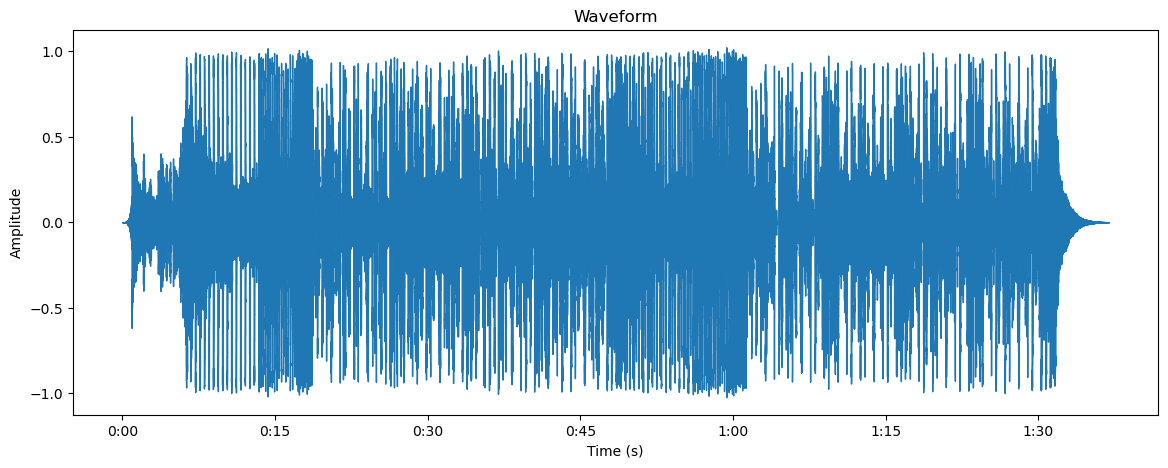

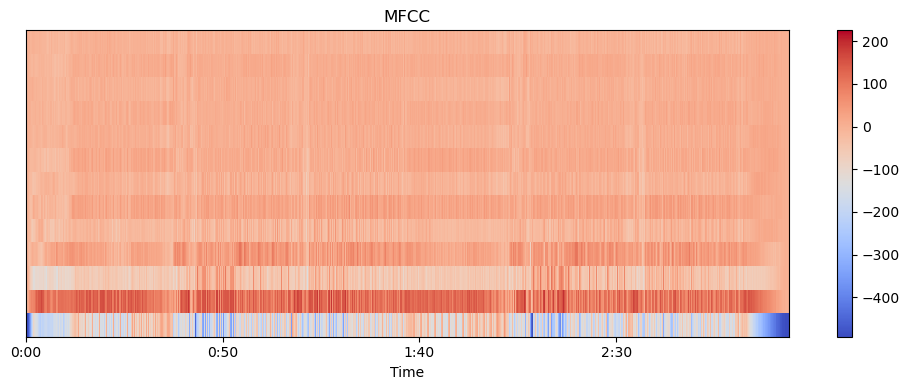

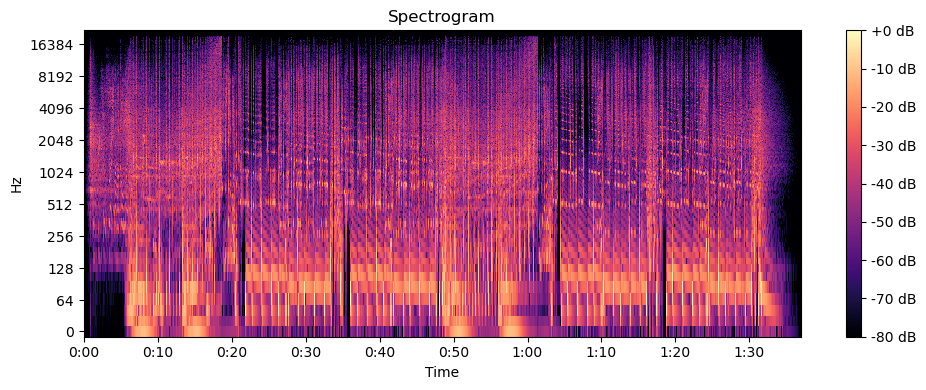

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 1. 读取音频文件
audio_path = 'data/rock/so-fresh-315255.mp3'  # 替换成你的音频文件路径
y, sr = librosa.load(audio_path, sr=None)  # y 是波形数组，sr 是采样率

# 2. 可视化波形
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# 3. 提取并可视化梅尔频率倒谱系数 (MFCC)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# 4. 提取频谱图 (Spectrogram)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

In [10]:
import os 
data_dir = 'data'  # adjust if your folder is elsewhere

genres = os.listdir(data_dir)
print("Genres found:", genres)

for genre in genres:
    genre_path = os.path.join(data_dir, genre)
    files = os.listdir(genre_path)
    print(f"{genre}: {len(files)} files")

Genres found: ['rnb', 'rock', 'jazz']
rnb: 20 files
rock: 20 files
jazz: 20 files


In [12]:
def trim_song(input_path, output_path, duration=30):
    y, sr = librosa.load(input_path, duration=duration)
    sf.write(output_path, y, sr)



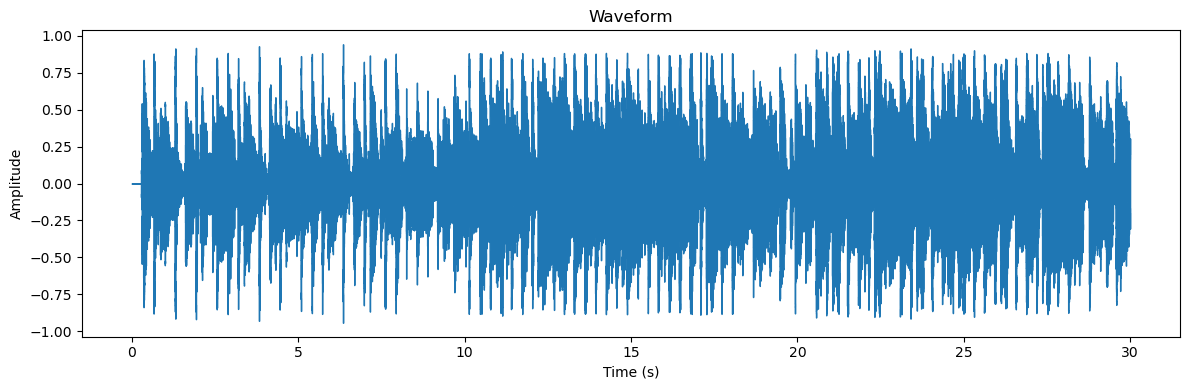

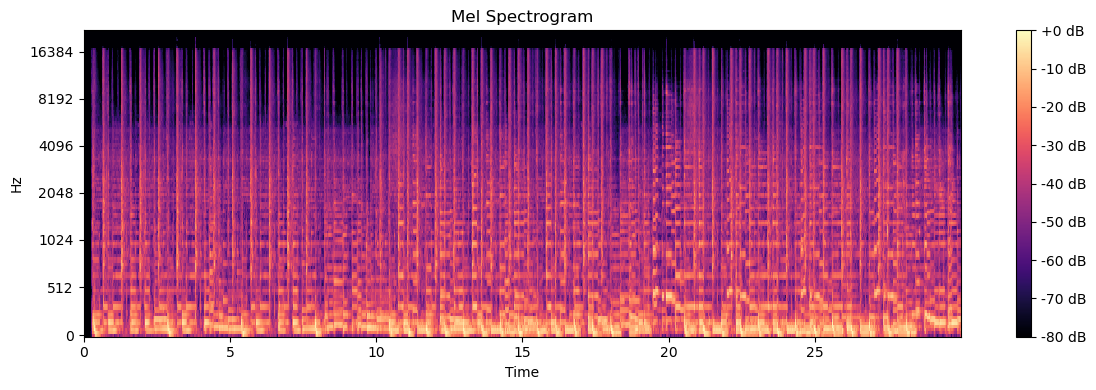

In [14]:
file_path = 'data/rock/commercial-rock-blues-328175.mp3'  

y, sr = librosa.load(file_path, sr=None, duration=30)  

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [16]:
def slice_spectrogram(mel_spec, slice_width=128):
    slices = []
    total_frames = mel_spec.shape[1]

    for start in range(0, total_frames - slice_width + 1, slice_width):
        slice_img = mel_spec[:, start:start + slice_width]
        if slice_img.shape[1] == slice_width:
            slices.append(slice_img)
    
    return slices

mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

slices = slice_spectrogram(mel_db)
print(f"Sliced into {len(slices)} patches")

Sliced into 20 patches


In [18]:
from tqdm import tqdm

def process_dataset(data_dir='data'):
    X = []
    y = []
    genres = os.listdir(data_dir)
    
    for genre in genres:
        genre_path = os.path.join(data_dir, genre)
        for file in tqdm(os.listdir(genre_path), desc=f'Processing {genre}'):
            try:
                file_path = os.path.join(genre_path, file)
                y_audio, sr = librosa.load(file_path, sr=None, duration=30)
                mel_spec = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=128)
                mel_db = librosa.power_to_db(mel_spec, ref=np.max)
                slices = slice_spectrogram(mel_db)

                for slice_img in slices:
                    if slice_img.shape == (128, 128):
                        X.append(slice_img)
                        y.append(genre)

            except Exception as e:
                print(f"Error with {file_path}: {e}")

    return np.array(X), np.array(y)

In [20]:
pip install tensorflow-macos

Note: you may need to restart the kernel to use updated packages.


In [22]:
# 获取数据
X, y = process_dataset()

# reshape + normalize
X = X[..., np.newaxis] / 255.0

# 标签编码
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# 最终形状
print(f"X shape: {X.shape}, y shape: {y_cat.shape}")
print("Genre classes:", encoder.classes_)

Processing jazz: 100%|██████████| 20/20 [00:01<00:00, 14.87it/s]

X shape: (1206, 128, 128, 1), y shape: (1206, 3)
Genre classes: ['jazz' 'rnb' 'rock']


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  # 3 genres
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,131 (28.20 MB)

 Trainable params: 7,392,131 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(X, y_cat, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.4489 - loss: 1.5261 - val_accuracy: 0.0000e+00 - val_loss: 1.2158
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.4703 - loss: 1.0139 - val_accuracy: 0.0000e+00 - val_loss: 1.4084
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.7033 - loss: 0.7983 - val_accuracy: 0.0000e+00 - val_loss: 1.4097
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7192 - loss: 0.6819 - val_accuracy: 0.0000e+00 - val_loss: 1.5369
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7083 - loss: 0.6860 - val_accuracy: 0.0000e+00 - val_loss: 1.3721
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7389 - loss: 0.5947 - val_accuracy: 0.0000e+00 - val_loss: 1.3054
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7547 - loss: 0.5729 - val_accuracy: 0.0000e+00 - val_loss: 1.3122
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7450 - loss: 0.563

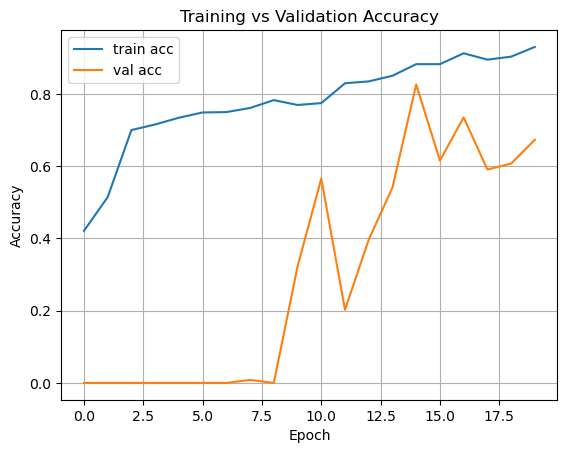

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Training vs Validation Accuracy")
plt.show()

In [30]:
def predict_genre_for_song(file_path, model, encoder, slice_width=128):
    y_audio, sr = librosa.load(file_path, sr=None, duration=30)
    mel_spec = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    slices = slice_spectrogram(mel_db, slice_width=slice_width)

    predictions = []
    for slice_img in slices:
        if slice_img.shape == (128, 128):
            slice_input = slice_img[np.newaxis, ..., np.newaxis] / 255.0
            pred = model.predict(slice_input, verbose=0)
            predictions.append(pred[0])

    # Softmax 平均 + argmax 得出最终类别
    avg_pred = np.mean(predictions, axis=0)
    genre_index = np.argmax(avg_pred)
    genre_label = encoder.inverse_transform([genre_index])[0]

    return genre_label

In [32]:
genre = predict_genre_for_song("data/rnb/dreamy-meadow-157900.mp3", model, encoder)
print("Predicted Genre:", genre)

Predicted Genre: rnb


In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = []
pred_labels = []

data_dir = "data"
for genre in os.listdir(data_dir):
    genre_path = os.path.join(data_dir, genre)
    for fname in os.listdir(genre_path):
        if fname.endswith(".mp3") or fname.endswith(".wav"):  # 确保是音频文件
            file_path = os.path.join(genre_path, fname)
            try:
                pred = predict_genre_for_song(file_path, model, encoder)
                pred_labels.append(pred)
                true_labels.append(genre)
            except Exception as e:
                print(f"Error predicting {fname}: {e}")

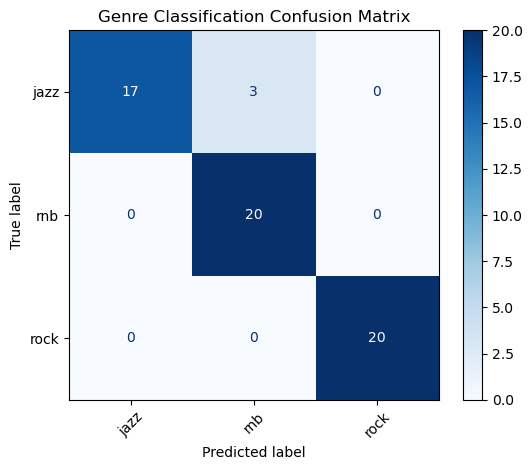

In [39]:
cm = confusion_matrix(true_labels, pred_labels, labels=encoder.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Genre Classification Confusion Matrix")
plt.grid(False)
plt.show()